# Hydroclimatic hazard modeling:

- Author: Eunkyoung Choi (kyoung.choi@colostate.edu)
- Version: Nov 21, 2022

In [42]:
## Import packages:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns; sns.set()
from math import sqrt
import plotly.graph_objects as go
import linearmodels.panel
from scipy import stats
import plotly.figure_factory as ff
import plotly.express as px
plt.style.use('seaborn-whitegrid')
import matplotlib
import warnings
warnings.filterwarnings('ignore')
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

In [36]:
# ## some setting:
# pd.set_option('display.max_rows', 5000)
# pd.set_option('display.max_columns', 500)

# from matplotlib import rc
# plt.rcParams['ps.useafm'] = True
# rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
# plt.rcParams['pdf.fonttype'] = 42 #pdf plot

# def geoid_format(data):
#     data['GEOID'] = data['GEOID'].astype(str).str.zfill(5)
#     data['time'] = pd.to_datetime(data['time'])
#     data['year'] = data['time'].dt.year
#     print(data.shape)
#     return data


# 1) Option
- Options to select:

In [ ]:
'''
Please select which one to model:
crop_name = Maize, Soybeans, Spring Wheat, Sorghum
crop_yld_name = maize_yld, soy_yld, spr_wheat_yld, sorghum_yld
water_demand= prism_vpdmean, ag_prism_short_eto, agera5_short_eto

Note:
1. ETc vs. ETo: select ETo as ETo can be adjusted to ETc later
2. selected_growing here indicates the full growing season to derive the Kc curve.
3. final_growing_season is based on the growing phases which provided best explantory power from cross-validation.
3. df is a processed dataframe. The processing files are included in data and can be obtained as requested to the authors.

'''
############################## Please provide an option to run the model below ####################
crop_name = 'Sorghum'

crop_yld_name = 'sorghum_yld'

water_demand = 'prism_vpdmean'



In [2]:
############### naming for variables and default path ######################################################################

data_name = 'PRISM'
rsm1 = 'ldas_sm_total_100cm'
rsm2 = 'ldas_sm_total_40cm'
rsm3 = 'ldas_sm_0_10cm'
path_d = 'C:/Users/kyoun/Documents/research/4_Hazard-Analysis/4_Hydrological_Hazard/3_Irrigated_filtered_analysis/1_combine_dataframe/1_combine_dataframe/1_eto/1_cropland_weighted/'

#### cut_off for defining the hydroclimatic hazards for ECDF #######
cut_off = 15

################################### Setting ################################################################################
if crop_yld_name == 'maize_yld':
    if water_demand == 'prism_vpdmean':
        selected_growing = ['PLANTED','EMERGED','SILKING','DOUGH','DENTED']
    else:
        selected_growing = ['PLANTED','EMERGED','SILKING','DOUGH','DENTED','MATURE','HARVESTED'] 
    df = pd.read_parquet(path_d+'final_maize_combined_cropland_weighted_all_df_9June2022.gzip')
elif crop_yld_name == 'soy_yld':
    if water_demand == 'prism_vpdmean':
        selected_growing = selected_growing = ['PLANTED','EMERGED', 'BLOOMING','SETTING PODS']
    else:
        selected_growing = ['PLANTED','EMERGED', 'BLOOMING','SETTING PODS', 'DROPPING LEAVES','HARVESTED']
    df = pd.read_parquet(path_d+'final_soybeans_combined_cropland_weighted_all_df_9June2022.gzip')
elif crop_yld_name == 'spr_wheat_yld':
    if water_demand == 'prism_vpdmean':
        selected_growing = ['PLANTED','EMERGED','HEADED']
    else:
        selected_growing = ['PLANTED','EMERGED','HEADED','HARVESTED']
    df= pd.read_parquet(path_d+'final_spring_wheat_combined_cropland_weighted_all_df_9June2022.gzip')
elif crop_yld_name == 'sorghum_yld':
    if water_demand == 'prism_vpdmean':
        selected_growing = ['PLANTED','EMERGED','HEADED','COLORING']
    else:
        selected_growing = ['PLANTED','EMERGED','HEADED','COLORING','MATURE','HARVESTED'] #
    df= pd.read_parquet(path_d+'final_sorghum_combined_cropland_weighted_all_df_9June2022.gzip')

############################################################################################################################
################################# Aggregating soil moisture for 100 cm #####################################################
############################################################################################################################
df['ldas_sm_total_40cm'] = ((df.ldas_sm_0_10cm * 100) + (df.ldas_sm_10_40cm * 300)) * (1/400)
df['ldas_sm_total_100cm'] = ((df.ldas_sm_0_10cm * 100) + (df.ldas_sm_10_40cm * 300) + (df.ldas_sm_40_100cm * 600)) * (1/1000)
df['prism_vpdmean'] = df['prism_vpdmean'] * 0.1

############################################################################################################################
################################# Choosing counties with 20 years of obs ###################################################
############################################################################################################################
yr_df = df.loc[(df['growing_phase'].isin(selected_growing)) & (df['yld_count_until2020'] >=20)].dropna(subset=[crop_yld_name,'prism_vpdmean','agera5_avg_vpd_kpa','agera5_short_eto']).copy()

In [3]:
############################################################################################################################
################################ custom-functions ##########################################################################
############################################################################################################################

#### converting bushel per acre into kg/ha ###
def conv_yld(data, crop_yld_name, ton_kg):
    ## Based on USDA 1979 book (reference) ##
    if ton_kg == 'ton':
        print('ton->')
        if crop_yld_name in ('maize_yld','sorghum_yld'):
            print(crop_yld_name)
            data['tonha_'+crop_yld_name] = data[crop_yld_name] * 1/39.368 * 1/0.404686
        elif crop_yld_name in ('soy_yld','spr_wheat_yld'):
            print(crop_yld_name)
            data['tonha_'+crop_yld_name] = data[crop_yld_name] * 1/36.744 * 1/0.404686
    elif ton_kg == 'kg':
        print('kg->')
        if crop_yld_name in ('maize_yld','sorghum_yld'):
            print(crop_yld_name)
            data['kgha_'+crop_yld_name] = data[crop_yld_name] * 1/0.039368 * 1/0.404686
        elif crop_yld_name in ('soy_yld','spr_wheat_yld'):
            print(crop_yld_name)
            data['kgha_'+crop_yld_name] = data[crop_yld_name] * 1/0.036744 * 1/0.404686
    return data



# 2) Visualization of data (Supplementary figures S9 & S10)
## 2-1) spatial map of rainfed vs. irrigated counties - Avg. Yields

In [8]:
################################# please provide the range #################################################################
zminn = 0
zmaxx = 100
temp_df = yr_df[['GEOID','time',crop_yld_name,'irri_counties',]].groupby(['GEOID','irri_counties'])[crop_yld_name].mean().reset_index()

################################# rainfed counties #########################################################################
fig = go.Figure(go.Choropleth( locationmode='geojson-id', geojson=counties, locations=temp_df.loc[temp_df['irri_counties']=='No']['GEOID'],
                              z=temp_df.loc[temp_df['irri_counties']=='No'][crop_yld_name], colorscale="viridis",
                              zmin=zminn, zmax=zmaxx,
                              colorbar={'outlinecolor':'black', 'outlinewidth':3,'tickfont':dict(size=20,family='Arial'),
                                       'orientation':'h','xanchor':'center','y':-0.45,'x':0.46,'len':0.6,'thickness':20},
                              marker_line_width=0,
                              colorbar_title=dict(text='Average Annual Yield (kg/ha)', font_family='Arial', side='top',
                                                  font_size=18)
                             ))

############################### irrigated counties #########################################################################
fig1 = go.Choropleth(locationmode='geojson-id',geojson=counties, locations=temp_df.loc[temp_df['irri_counties']=='Yes']['GEOID'],
                          z=temp_df.loc[temp_df['irri_counties']=='Yes'][crop_yld_name], colorscale="viridis",
                     zmin=zminn, zmax=zmaxx, showscale=False, colorbar={'outlinecolor':'black', 'outlinewidth':3},
                          marker_line_width=0.7, marker_line_color='black')

############################## state outlines ##############################################################################
fig2 = go.Choropleth(locationmode='USA-states',locations=temp_df['state'].unique(),
                    z=temp_df[['state','nonee']]['nonee'],
                    colorscale=[[0,'rgba(0,0,0,0)'],[1,'rgba(0,0,0,0)']], showscale=False, marker_line_width=0.6,marker_line_color='black')
                              
fig.add_trace(fig1)
fig.add_trace(fig2)
fig.update_geos(visible=False, scope='usa',
               showsubunits=True,  subunitcolor='black', subunitwidth=1)

############################# saving figure ################################################################################
#fig.write_image('fig/supplementary/'+crop_name+'_'+title_text+'_1981_2020.png',width=600, height=500, scale=1.5)#, dpi=300)
fig.show()

del temp_df

## 2-2) spatial map of rainfed counties with the number of obs. 
- thsese are the counties that were used in our analysis

In [16]:
temp_df = yr_df.loc[yr_df['irri_counties'] == 'No'][['GEOID','time',crop_yld_name]].copy()
temp_df['year'] = temp_df['time'].dt.year
temp_df = temp_df[['GEOID','year',crop_yld_name]].drop_duplicates().groupby(['GEOID'])[crop_yld_name].count().reset_index()
temp_df['bins'] = pd.cut(temp_df[crop_yld_name],bins=[19,20,25,30,35,40], retbins=True)[0]
temp_df = temp_df.sort_values(by='bins',ascending=False)
fig = px.choropleth(temp_df, geojson=counties, locations='GEOID',
             color=temp_df['bins'].astype(str),
            scope='usa', labels={'color':'N years'},
            color_discrete_sequence=['rgb(253,231,37)','rgb(180,222,44)','rgb(53,183,121)','rgb(38,130,142)','rgb(68,1,84)']
                   )

#fig.write_image('fig/supplementary/'+crop_name+'_'+title_text+'_1981_2020.png',width=600, height=500, scale=1.5)                             
fig.show()

del temp_df

# 3) Creating the dataframe for crop-specific hydroclimatic model:
## 3-1) selecting rainfed counties and water-demand related data preprocessing

In [ ]:
## selecting rainfed counties:
put_data = yr_df.loc[yr_df['irri_counties'] == 'No'][['GEOID','time','year',crop_yld_name,'state','irri_counties','ldas_sm_total_100cm','prism_tmin',
                    'prism_vpdmean','ag_prism_short_eto', 'agera5_short_eto', 'week_50','growing','growing_phase','yld_count_until2020']].copy()

In [18]:
## water-demand related preprocessing ######################################################################################
'''
- If water demand is vpd, it will just select the optimal growing phases that provided the best explantory power from CV.
- If water demand is crop-specific ET, we calculate Kc below:
    - We followed the FAO standard methods for ETc.
    - We then select the optimal growing phases.
'''

if water_demand == 'agera5_short_eto' or water_demand == 'ag_prism_short_eto':
    print('Your water demand: ', water_demand)
    water_demand_name = 'ETc (mm)'
    put_data['full_gs_days'] = put_data.groupby(['GEOID','year'])[rsm1].transform('count')
    print(put_data['full_gs_days'].unique(), put_data.groupby(['state','GEOID','year'])[rsm1].size().unique())
    if crop_yld_name == 'maize_yld':
        put_data = put_data.sort_values('time')
        put_data['kc'] = np.nan
        ### initial stage (constant Kc):
        put_data.loc[put_data['growing_phase'].isin(['PLANTED']),'kc'] = 0.30
        put_data.loc[put_data['growing'].isin(['EMERGED']),'kc'] = 0.30  
        ### mid-season stage (constant Kc):
        put_data.loc[put_data['growing_phase'].isin(['SILKING','DOUGH','DENTED']),'kc'] = 1.20

        ### assign kc to the last day of harvested:
        put_data.loc[put_data.loc[put_data['growing_phase'] == 'HARVESTED'].groupby(['GEOID','year']).tail(1).index, 'kc'] = 0.4

        ### linearly interpolate Kc for the development and mid-season:
        put_data['kc'] = put_data.groupby(['GEOID','year'])['kc'].apply(lambda x:x.interpolate(method='linear', limit_direction='forward'))

        ## calculating ETc = ETo * Kc
        selected_growing = ['PLANTED','EMERGED','SILKING','DOUGH','DENTED']
        print(put_data.shape)
    elif crop_yld_name == 'soy_yld':
        put_data = put_data.sort_values('time')
        put_data['kc'] = np.nan
        ### initial stage (constant Kc):
        put_data.loc[put_data['growing_phase'].isin(['PLANTED']),'kc'] = 0.40
        put_data.loc[put_data['growing'].isin(['EMERGED']),'kc'] = 0.40

        ### mid-season stage (constant Kc):
        put_data.loc[put_data['growing_phase'].isin(['BLOOMING','SETTING PODS']),'kc'] = 1.15

        ### assign kc to the last day of harvested:
        put_data.loc[put_data.loc[put_data['growing_phase'] == 'HARVESTED'].groupby(['GEOID','year']).tail(1).index, 'kc'] = 0.5

        ### linearly interpolate Kc for the development and mid-season:
        put_data['kc'] = put_data.groupby(['GEOID','year'])['kc'].apply(lambda x:x.interpolate(method='linear', limit_direction='forward'))

        ## select the best growing season:
        selected_growing = ['PLANTED','EMERGED', 'BLOOMING','SETTING PODS']
    elif crop_yld_name == 'spr_wheat_yld':
        put_data = put_data.sort_values('time')
        put_data['kc'] = np.nan
        ### initial stage (constant Kc):
        put_data.loc[put_data['growing_phase'].isin(['PLANTED']),'kc'] = 0.40
        put_data.loc[put_data['growing'].isin(['EMERGED']),'kc'] = 0.40

        ### mid-season stage (constant Kc):
        put_data.loc[put_data['growing_phase'].isin(['HEADED']),'kc'] = 1.15

        ### assign kc to the last day of harvested:
        put_data.loc[put_data.loc[put_data['growing_phase'] == 'HARVESTED'].groupby(['GEOID','year']).tail(1).index, 'kc'] = 0.3

        ### linearly interpolate Kc for the development and mid-season:
        put_data['kc'] = put_data.groupby(['GEOID','year'])['kc'].apply(lambda x:x.interpolate(method='linear', limit_direction='forward'))

        ## select the best growing season:
        selected_growing = ['PLANTED','EMERGED', 'HEADED']
    elif crop_yld_name == 'sorghum_yld':
        put_data = put_data.sort_values('time')
        put_data['kc'] = np.nan
        ### initial stage (constant Kc):
        put_data.loc[put_data['growing_phase'].isin(['PLANTED']),'kc'] = 0.30
        put_data.loc[put_data['growing'].isin(['EMERGED']),'kc'] = 0.30 

        ### mid-season stage (constant Kc):
        put_data.loc[put_data['growing_phase'].isin(['HEADED','COLORING']),'kc'] = 1.10

        ### assign kc to the last day of harvested:
        put_data.loc[put_data.loc[put_data['growing_phase'] == 'HARVESTED'].groupby(['GEOID','year']).tail(1).index, 'kc'] = 0.55

        ### linearly interpolate Kc for the development and mid-season:
        put_data['kc'] = put_data.groupby(['GEOID','year'])['kc'].apply(lambda x:x.interpolate(method='linear', limit_direction='forward'))

        ## select the best growing season:
        selected_growing = ['PLANTED','EMERGED', 'HEADED', 'COLORING']

    ## for all:    
    put_data[water_demand] = put_data[water_demand] * put_data['kc']
    put_data = put_data.loc[put_data['growing_phase'].isin(selected_growing)]
    print(put_data.shape)
    
else:
    print('Your water demand: ', water_demand)
    water_demand_name = 'VPD (kPa)'
    if crop_yld_name == 'maize_yld':
        selected_growing = ['PLANTED','EMERGED','SILKING','DOUGH','DENTED']
    elif crop_yld_name == 'soy_yld':
        selected_growing = ['PLANTED','EMERGED', 'BLOOMING','SETTING PODS']
    elif crop_yld_name == 'spr_wheat_yld':
        selected_growing = ['PLANTED','EMERGED', 'HEADED']
    elif crop_yld_name == 'sorghum_yld':
        selected_growing = ['PLANTED','EMERGED', 'HEADED', 'COLORING']
    print(crop_name, selected_growing)

Your water demand:  prism_vpdmean
Sorghum ['PLANTED', 'EMERGED', 'HEADED', 'COLORING']


## 3-2) Binning process:

In [23]:
################### Setting for binning #####################################################################################
set_qcut = [0,0.1, 0.30, 0.50, 0.70, 0.9, 1]
bin1_names1 = ['bin1','bin2','bin3','bin4','bin5','bin6']
bin2_names1 = ['v1','v2','v3','v4','v5','v6']
put_data['full_gs_days'] = put_data.groupby(['state','GEOID','year'])[rsm1].transform('count')

#############################################################################################################################
index_data = put_data.set_index(['GEOID','time']).copy()

## get the array of bins:
final_rsm_bins = pd.qcut(index_data[rsm1],q=set_qcut,retbins=True)[1] 
#print('rsm_bins:',final_rsm_bins)
final_vpd_bins = pd.qcut(index_data[water_demand],q=set_qcut, retbins=True)[1]
#print('vpd_bins:',final_vpd_bins)

## assing bins back to dataframe:
assign_bin_full = index_data.assign(rsm_cut=pd.qcut(index_data[rsm1],q=set_qcut,labels=bin1_names1),
                         vpd_cut=pd.qcut(index_data[water_demand],q=set_qcut,labels=bin2_names1))
#print('check if there is any missing bin assigned:', assign_bin_full.loc[assign_bin_full.vpd_cut.isnull()])

## renaming: combine the two bins into one unique bin of the full datasets
assign_bin_full_combine = assign_bin_full[['rsm_cut','vpd_cut']].apply(lambda x : '{}{}'.format(x[0],x[1]), axis=1)
assign_bin_full_combine = assign_bin_full_combine.rename('rsm_vpd_bin')
#print(sorted(assign_bin_full_combine.unique()))

## merge the sm_root and vpd dataframe with the original data.
final_full_bin = pd.merge(assign_bin_full_combine, index_data.reset_index(), on=['GEOID','time'], how='outer')

## memory clean
del index_data
del assign_bin_full, assign_bin_full_combine

In [24]:
## exposure bins 
n_b_full_bin_expo = pd.DataFrame(final_full_bin.groupby(['GEOID','year','rsm_vpd_bin'])[rsm1].count().rename('n_b')).reset_index()
n_b_full_bin = pd.merge(n_b_full_bin_expo, final_full_bin[['GEOID','year',crop_yld_name,'full_gs_days']].drop_duplicates(),
                       on=['GEOID','year'], how='outer', indicator=True)
#print(n_b_full_bin._merge.unique())
n_b_full_bin['percent_n_b'] = (n_b_full_bin['n_b'] / n_b_full_bin['full_gs_days']) * 100 #scaling to percent from days


In [26]:
## unstack data 
rho_unstack_full = n_b_full_bin[['GEOID','year',crop_yld_name, 'rsm_vpd_bin','percent_n_b']].set_index(['GEOID','year',crop_yld_name,'rsm_vpd_bin']).unstack()
rho_unstack_full.columns = rho_unstack_full.columns.droplevel()
rho_unstack_full = rho_unstack_full.replace(np.nan,0).reset_index()  

In [27]:
final_combined_1 = rho_unstack_full.copy()
del n_b_full_bin_expo

## 3-3) Temperature control:

In [30]:
############################ settings ########################################################################################
if crop_yld_name == 'maize_yld':
    opt_temp_limit = 10
elif crop_yld_name == 'soy_yld':
    opt_temp_limit = 8
elif crop_yld_name == 'sorghum_yld':
    opt_temp_limit = 3
else:
    opt_temp_limit = None
    
## counting exposure days to low temperatures
var1 = 'prism_tmin'
rho_unstack_temp = final_full_bin.loc[final_full_bin[var1] < opt_temp_limit ].groupby(['GEOID','year'])[var1].agg(['count','mean']).reset_index()
rho_unstack_temp['percent_n_b_temp'] = rho_unstack_temp['count'] / final_full_bin.loc[final_full_bin[var1] < opt_temp_limit ][['GEOID','year','full_gs_days']].drop_duplicates(ignore_index=True)['full_gs_days'] * 100

## combining all
final_combined_full = pd.merge(rho_unstack_full, rho_unstack_temp, on=['GEOID','year'], how='outer', indicator=True)
final_combined_full = final_combined_full.replace(np.nan, 0)

## 3-4) combine all togheter:

In [31]:
## only for maize, sorghum and soybeans
if (crop_yld_name == 'maize_yld') or (crop_yld_name == 'soy_yld') or (crop_yld_name == 'sorghum_yld'):
    final_combined_1 = final_combined_full.copy()
final_combined_1 = conv_yld(final_combined_1, crop_yld_name, 'kg')  

kg->
sorghum_yld


# 4) Model:
## 4-1) Model settings:

In [33]:
####################################### setting #############################################################################
model5_eq = ('kgha_'+crop_yld_name +' ~ bin1v1+bin1v2+bin1v3+bin1v4+bin1v5+bin1v6+bin2v1+bin2v2+bin2v3+bin2v4+bin2v5+bin2v6+'+
                 'bin3v1+bin3v2+bin3v3+bin3v4+bin3v5+bin3v6+bin4v1+bin4v2+bin4v3+bin4v4+bin4v5+bin4v6+bin5v1+bin5v2+bin5v3+bin5v4+bin5v5+bin5v6+'+
                 'bin6v1+bin6v2+bin6v3+bin6v4+bin6v5+bin6v6+C(year, Treatment(reference=1981.0))')

if water_demand == 'prism_vpdmean':
    print(water_demand)
    if crop_yld_name == 'maize_yld':
        opt_bin = 'bin2v3'
        print(crop_yld_name, opt_bin)
        model5_eq = model5_eq + '+C(GEOID, Treatment(reference="13029"))' + '+percent_n_b_temp'
                
    elif crop_yld_name == 'soy_yld':
        opt_bin = 'bin5v3'
        print(crop_yld_name, opt_bin)
        model5_eq = model5_eq + '+C(GEOID, Treatment(reference="01003"))' + '+percent_n_b_temp'
        
    elif crop_yld_name == 'spr_wheat_yld':
        opt_bin = 'bin4v4'
        print(crop_yld_name, opt_bin)
        model5_eq = model5_eq + '+C(GEOID, Treatment(reference="16009"))'
        
    elif crop_yld_name == 'sorghum_yld':    
        opt_bin = 'bin5v2'
        print(crop_yld_name, opt_bin)
        model5_eq = model5_eq + '+C(GEOID, Treatment(reference="05063"))' + '+percent_n_b_temp'
elif water_demand == 'ag_prism_short_eto':
    print(water_demand)
    if crop_yld_name == 'maize_yld':
        opt_bin = 'bin5v4'
        print(crop_yld_name, opt_bin)
        model5_eq = model5_eq + '+C(GEOID, Treatment(reference="13029"))' + '+percent_n_b_temp'
                
    elif crop_yld_name == 'soy_yld':
        opt_bin = 'bin5v4'
        print(crop_yld_name, opt_bin)
        model5_eq = model5_eq + '+C(GEOID, Treatment(reference="01003"))' + '+percent_n_b_temp'
        
    elif crop_yld_name == 'spr_wheat_yld':
        opt_bin = 'bin3v2'
        print(crop_yld_name, opt_bin)
        model5_eq = model5_eq + '+C(GEOID, Treatment(reference="16009"))'
        
    elif crop_yld_name == 'sorghum_yld':    
        opt_bin = 'bin6v4'
        print(crop_yld_name, opt_bin)
        model5_eq = model5_eq + '+C(GEOID, Treatment(reference="05063"))' + '+percent_n_b_temp'
elif water_demand == 'agera5_short_eto':
    print(water_demand)
    if crop_yld_name == 'maize_yld':
        opt_bin = 'bin5v4'
        print(crop_yld_name, opt_bin)
        model5_eq = model5_eq + '+C(GEOID, Treatment(reference="13029"))' + '+percent_n_b_temp'
                
    elif crop_yld_name == 'soy_yld':
        opt_bin = 'bin5v4'
        print(crop_yld_name, opt_bin)
        model5_eq = model5_eq + '+C(GEOID, Treatment(reference="01003"))' + '+percent_n_b_temp'
        
    elif crop_yld_name == 'spr_wheat_yld':
        opt_bin = 'bin5v5'
        print(crop_yld_name, opt_bin)
        model5_eq = model5_eq + '+C(GEOID, Treatment(reference="16009"))'
        
    elif crop_yld_name == 'sorghum_yld':    
        opt_bin = 'bin6v4'
        print(crop_yld_name, opt_bin)
        model5_eq = model5_eq + '+C(GEOID, Treatment(reference="05063"))' + '+percent_n_b_temp'
model5_eq = model5_eq.replace('+'+opt_bin, '')




prism_vpdmean
sorghum_yld bin5v2


## 4-2) Fitting the model:

In [46]:
### fit data:
fit_both_full_1 = smf.ols(formula = model5_eq, data=final_combined_1).fit(
                                              cov_type='nw-groupsum',
                                              cov_kwds={'time': np.array(final_combined_1['year'].astype(int)),
                                                        'groups': np.array(final_combined_1['GEOID']),
                                                        'maxlags': 1},
                                              use_t=True)
fit_both_full_1.summary()

In [109]:
## saving the dataframe 
final_combined_1['pred'] = fit_both_full_1.fittedvalues
final_combined_1.to_parquet(crop_name +'_final_model_fitting_df.gzip', compression='gzip')
fit_both_full_1.save(crop_yld_name+'_'+water_demand+'_fit.pickle')

# 5) Figure 1. Yield sensitivity

In [39]:
###########################################################################################################################
################################### Custom functions for figures ##########################################################
###########################################################################################################################
with_temp = 'Yes' # this 'Yes','No' came from testing the effects of temperatures. keep "yes"

def labels(bin1, bin2):
    rsm_2 = np.round(bin1,2).astype('str')
    vpd_2 = np.round(bin2,2).astype('str')
    print(rsm_2, vpd_2)
    x_labels= ['  '+rsm_2[0]+'  '+rsm_2[1],'         '+rsm_2[2],'        '+rsm_2[3] ,'       '+rsm_2[4],'      '+rsm_2[5],'    '+rsm_2[6]]
    y_labels= [vpd_2[1]+'\n\n'+vpd_2[0],vpd_2[2]+'\n\n',vpd_2[3]+'\n\n',vpd_2[4] +'\n\n',vpd_2[5]+'\n\n',vpd_2[6]+'\n\n']
    return x_labels, y_labels

def coefficient_2d(fit_model_result, total_bins, crop_yld_name):
    if crop_yld_name == 'spr_wheat_yld':
        coef_min = -35
        coef_max = None
    else:
        if with_temp == 'Yes':
            coef_min = -36
            coef_max = -1
        else:
            coef_min = -35
            coef_max = None
            
    ### coefficient:        
    cor_full = pd.DataFrame(fit_model_result.params[coef_min:coef_max].round(1), columns=['coef']).reset_index()
    split_col_full = cor_full["index"].str.split("v", n = 1, expand = True)
    col1_full = pd.concat([split_col_full,cor_full],1)
    pivot_cor_full = col1_full.pivot(index=1,columns=0,values='coef')
    del cor_full, split_col_full, col1_full
    return pivot_cor_full

def plot_2d(data,annote, xlabel, ylabel, crop_yld_name, water_demand_name, title, namee, footnote):
    if crop_yld_name in ('maize_yld'):
        if water_demand == 'prism_vpdmean':
            vminn = -120
            cvals = [-120, -90, -60, -48, -36 ,-24, -12, 0]
        else:
            vminn = -135
            cvals = [-135, -101.25, -67.5, -54, -40.5, -27, -13.5, 0]
    elif crop_yld_name in ('soy_yld'):
        if water_demand == 'prism_vpdmean':
            vminn = -30
            cvals = [-30, -22.5, -15, -12, -9, -6, -3, 0]
        else:
            vminn = -40
            cvals = [-40, -28 ,-16 ,-12,-8, -4 ,0]
    elif crop_yld_name in ('sorghum_yld'):
        if water_demand == 'prism_vpdmean':
            vminn = -70
            cvals = [-70, -52.5, -35, -28, -21, -14, -7, 0]
        else:
            vminn = -80
            cvals = [-80, -60, -40,-32, -24, -16, -8, 0]
    elif crop_yld_name  in ('spr_wheat_yld'):
        if water_demand == 'prism_vpdmean':
            vminn = -55
            cvals = [-55, -41.25, -27.5, -22, -16.5, -11, -5.5,0]
        else:
            vminn = -60
            cvals = [-60, -45, -30, -24, -18, -12, -6]
    
    colors = ["black","darkred","tab:red","darkorange","orange","moccasin","cornsilk","whitesmoke"] #"tab:orange",

    norm=plt.Normalize(min(cvals),max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)
        
    fig, ax = plt.subplots(figsize=(10,11), tight_layout=True)  
    g = sns.heatmap(np.round(data,2),cmap=cmap, annot=annote,annot_kws={"size": 32.2},vmin=vminn, vmax=0,fmt="",  norm=norm, linewidth=2,
                    linecolor='gray',
                 xticklabels=xlabel, yticklabels=ylabel, ax=ax, cbar=False)
    g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 31)
    g.set_xticklabels(g.get_xticklabels(), rotation = 0, fontsize = 31)
    g.figure.axes[-1].tick_params(labelsize=31, pad=10)
    g.invert_yaxis()
    g.set_xlabel('~100 cm SM (m$^{3}$/m$^{3}$)',fontsize=33.5)
    g.set_ylabel(water_demand_name,fontsize=33.5)
    ax.patch.set_edgecolor('black')  
    ax.patch.set_linewidth(5)
    cbar = fig.colorbar(ax.collections[0], ax=ax, cmap=cmap,orientation='horizontal', aspect=12)
    cbar.outline.set_color('black')
    cbar.outline.set_linewidth(3)
    cbar.set_ticks([vminn,0])
    cbar.set_ticklabels([vminn,0])
    cbar.ax.tick_params(labelsize=31)
    cbar.set_label(label='Yield Sensitivity (kg/ha/%)',size=30,labelpad=-4)
    
    ## saving figures 
    #plt.savefig('fig/'+crop_name+'_'+water_demand+namee+'_yield_sensitivity_kc_wt_temp.pdf',dpi=90,bbox_inches='tight' )
    #plt.savefig('fig/'+crop_name+'_'+water_demand+namee+'_yield_sensitivity_kc_with_temp_'+with_temp+'.png',dpi=90,bbox_inches='tight' )
    #plt.figtext(0.12, -0.07, "  *: Adj. Stat. Significant (a<0.05)\n" +footnote, ha="left", fontsize=20, color='black') 
    #ax.set_title(title,size=25)
    plt.show()
    
def get_pval_onlyfixed(fitting, crop_yld_name):
    if crop_yld_name == 'spr_wheat_yld':
        coef_min = -35
        coef_max = None
    else:
        if with_temp == 'Yes':
            coef_min = -36
            coef_max = -1
        else:
            coef_min = -35 #36
            coef_max = None #-1
    
    pval_d = pd.DataFrame(fitting.pvalues[coef_min:coef_max].round(2).reset_index().rename(columns={0:'pval'}))
    pval_d['pvall'] = ''
    pval_d.loc[pval_d['pval'] < 0.05, 'pvall'] = '*'
    pval_d['pval'] = pval_d['pval'].astype(str)
    pval_d['p_val'] = pval_d['pval'] + pval_d['pvall']
    split_col = pval_d["index"].str.split("v", n = 1, expand = True)
    col1 = pd.concat([split_col,pval_d[['pvall']]],1)
    pivot_pval = col1.pivot(index=1,columns=0,values='pvall')
    return pivot_pval

In [48]:
cor_2d_1

,bin1,bin2,bin3,bin4,bin5,bin6
1,,,,,,
1,-54.9,-53.1,-46.9,-32.8,-38.0,-52.3
2,-18.9,-23.8,-17.7,-4.0,NaN,-11.4
3,-25.4,-5.6,-0.5,-11.2,-17.2,-22.1
4,-37.4,-38.0,-31.4,-26.4,-28.3,-33.1
5,-43.2,-40.1,-34.8,-33.8,-22.2,-9.0
6,-64.0,-63.1,-61.3,-62.3,-55.4,-24.5


['0.08' '0.23' '0.27' '0.29' '0.32' '0.35' '0.45'] ['0.0' '0.68' '1.05' '1.32' '1.66' '2.3' '5.36']


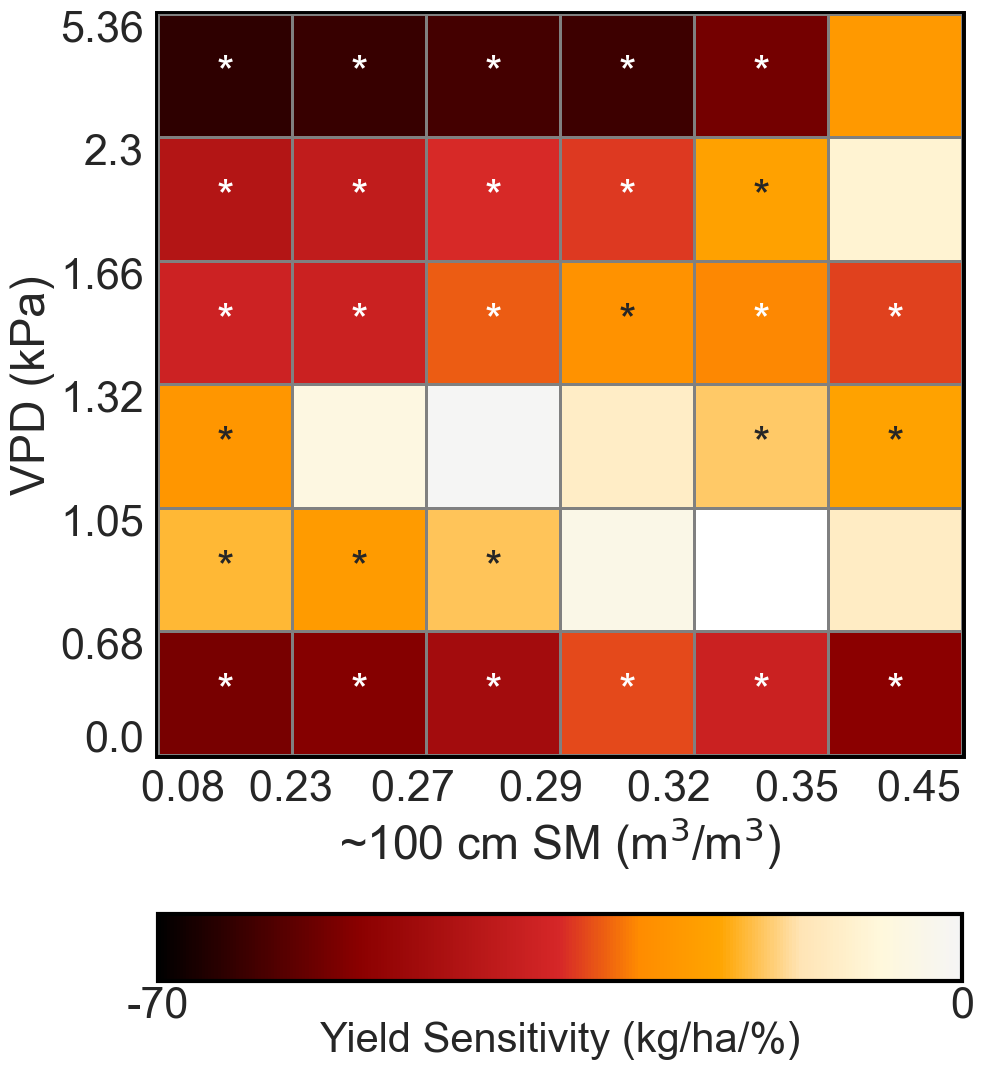

In [45]:
########### CHANGE THISSSSSSS !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!111
## getting x and y bin labels:
x_axis_labels_1, y_axis_labels_1 = labels(final_rsm_bins, final_vpd_bins)

## name for file saving 
growing_title = selected_growing[0]+'-'+selected_growing[-1]

## getting coefficient 2d 
cor_2d_1 = coefficient_2d(fit_both_full_1, 36, crop_yld_name)

## getting pvalues 
fixed_effect_pval1 = get_pval_onlyfixed(fit_both_full_1, crop_yld_name)

## plotting fig1:
plot_2d(cor_2d_1, fixed_effect_pval1.replace(np.nan, '').values,
        x_axis_labels_1, y_axis_labels_1, crop_yld_name, water_demand_name,
        crop_name + ' '+growing_title, None, None)

# 6) Distribution of residuals (Supplementary figure 11)

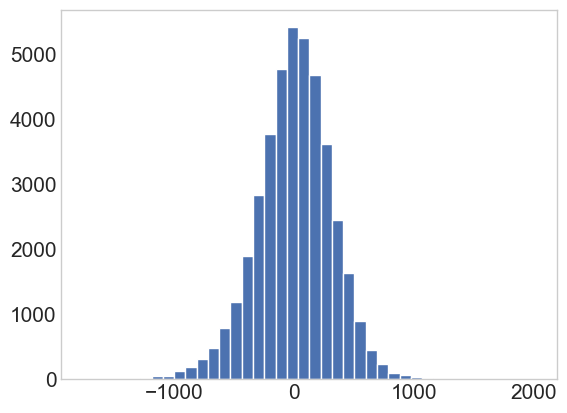

In [124]:
### normality of residuals:
fit_both_full_1.resid.hist(bins=40)
plt.tick_params(labelsize=15)
plt.grid(b=None)

## saving figure
#plt.savefig('fig/supplementary/'+crop_name+'_distribution_residuals.png',dpi=250)

In [36]:
### model stats:
(np.round(fit_both_full_1.rsquared,3).astype('str')+
"  adju_R2="+np.round(fit_both_full_1.rsquared_adj,3).astype('str')+
"  AIC="+np.round(fit_both_full_1.aic,2).astype('str')+ 
"  BIC="+np.round(fit_both_full_1.bic,2).astype('str')+
" RMSE="+np.round((sqrt(fit_both_full_1.mse_resid)),4).astype('str'))

'0.721  adju_R2=0.709  AIC=177114.01  BIC=180357.12 RMSE=752.1246'

# 7) Exposure Matrix (Supplementary figure S3)

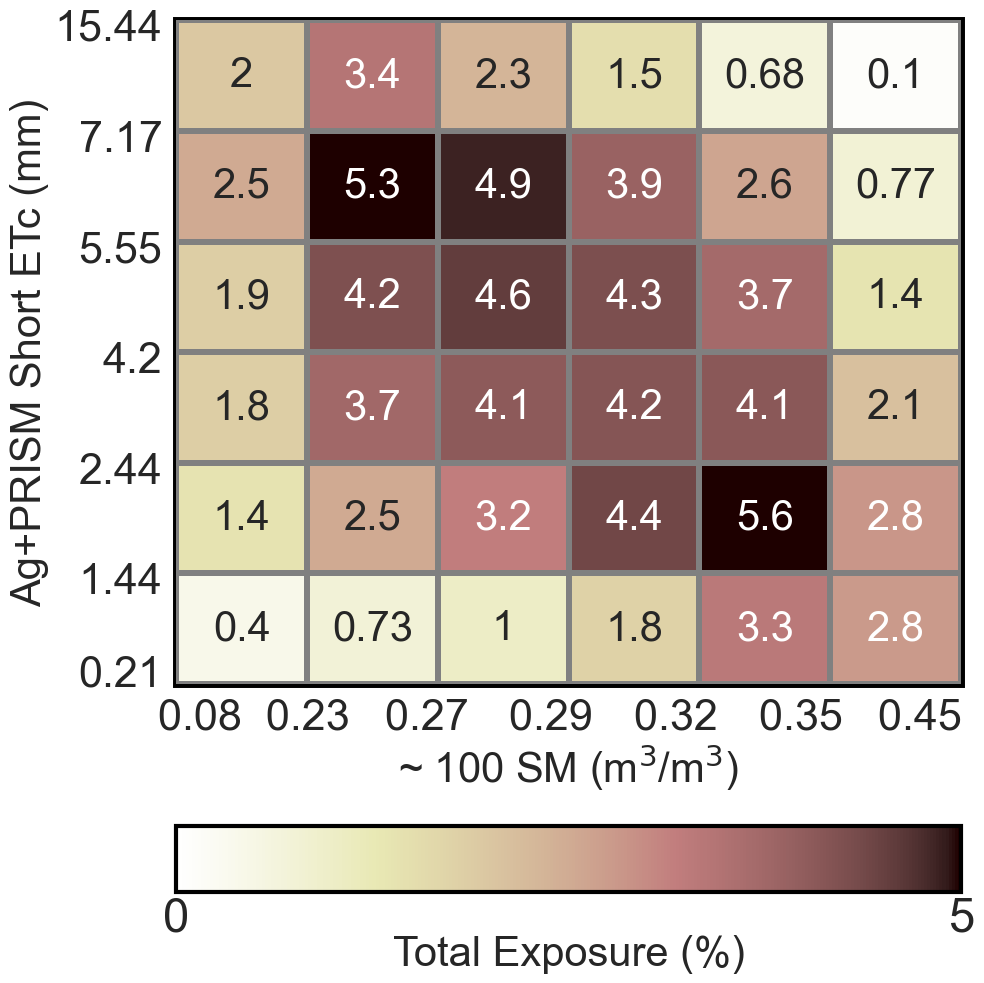

In [107]:
percent = (n_b_full_bin.groupby(['rsm_vpd_bin'])['n_b'].sum() / n_b_full_bin[['GEOID','year','full_gs_days']].drop_duplicates()['full_gs_days'].sum() * 100).reset_index()

percent['SM_bin'] = percent['rsm_vpd_bin'].str[:4]
percent['VPD_bin'] = percent['rsm_vpd_bin'].str[-2:]

freq_count = percent.pivot_table(index='VPD_bin', columns='SM_bin', values='n_b')

fig, ax = plt.subplots(1,1, figsize=(10,10),tight_layout=True)
g = sns.heatmap(freq_count,cmap='pink_r', annot=True,annot_kws={"size": 30}, vmin=0, vmax=5, 
                linewidth=3,linecolor='gray',#norm=norm
            xticklabels=x_axis_labels_1, yticklabels=y_axis_labels_1, ax=ax, cbar=False)
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 31)
g.set_xticklabels(g.get_xticklabels(), rotation = 0, fontsize = 31)
g.figure.axes[-1].tick_params(labelsize=31, pad=10)
g.invert_yaxis()
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth(5)
ax.set_ylabel(water_demand_name, fontsize=30)
ax.set_xlabel('~ 100 SM (m$^{3}$/m$^{3}$)',fontsize=30)
cbar = fig.colorbar(ax.collections[0], ax=ax, cmap='pink_r',orientation='horizontal',aspect=12)
cbar.outline.set_color('black')
cbar.set_ticks([0,5])
cbar.set_ticklabels([0,5])
cbar.outline.set_linewidth(3)
cbar.ax.tick_params(labelsize=34)
cbar.set_label(label='Total Exposure (%)',size=30, labelpad=-4)

## saving figure
#plt.savefig('fig/supplementary/'+crop_name+'_exposure_matrix_kc.png',dpi=300)
plt.show()

# 8) Cross-Validation (Supplementary table S1):

In [117]:
## demeaned data to remove the fixed effects:
drop_col =[]#['count','mean','_merge']#'_merge']#,'count','mean','percent_n_b_temp']
demeaned_df = linearmodels.panel.data.PanelData(final_combined_1.drop(columns=drop_col).set_index(['GEOID','year'])).demean(group='both')._frame.reset_index()
demeaned_df.head()

,GEOID,year,maize_yld,bin1v1,bin1v2,bin1v3,bin1v4,bin1v5,bin1v6,bin2v1,bin2v2,bin2v3,bin2v4,bin2v5,bin2v6,bin3v1,bin3v2,bin3v3,bin3v4,bin3v5,bin3v6,bin4v1,bin4v2,bin4v3,bin4v4,bin4v5,bin4v6,bin5v1,bin5v2,bin5v3,bin5v4,bin5v5,bin5v6,bin6v1,bin6v2,bin6v3,bin6v4,bin6v5,bin6v6,kgha_maize_yld
0,13029,1981.0,-13.282300,-1.567941,0.425881,-1.429277,-6.788427,-4.518680,13.159004,-0.251129,-0.248759,0.235720,0.964824,2.056152,1.342016,0.047134,0.551474,0.711759,0.720662,2.041637,1.502246,0.249088,1.098444,0.072568,-0.988943,-0.624243,0.332243,-0.688775,0.017826,-1.473720,-2.002570,-1.288798,-0.190016,-0.205312,-0.477081,-1.198825,-0.860308,-0.585653,-0.140224,-833.703774
1,13029,1982.0,23.410502,1.917554,1.471818,-2.916419,10.930055,-1.842123,-7.771325,-0.121575,0.117178,-0.152183,0.517037,1.609539,1.557846,-0.144461,-0.041203,-0.349069,-0.219577,0.450898,1.051462,-0.482499,-2.347460,-1.160343,-0.989461,-0.978532,0.332198,0.128656,-0.418118,-0.827732,-0.001618,-0.216008,0.052396,0.889619,0.222764,-0.291224,0.035989,-0.043393,0.029315,1469.430972
2,13029,1983.0,20.271522,5.165466,-3.176753,3.702181,-3.233707,1.710590,-4.653545,-0.026509,0.596874,0.742439,-0.201493,-3.225239,-2.901868,-0.166406,0.837702,1.400492,1.022342,-1.444789,-2.219482,0.523164,2.197361,1.098026,1.203753,0.037593,-0.460111,-0.009690,0.217985,0.955752,1.471497,0.880820,0.012506,-2.055850,-1.614548,0.460835,0.644637,0.406972,0.101004,1272.403392
3,13029,1984.0,15.860636,-1.239167,1.025720,-6.137271,4.464177,1.534074,0.836375,0.067950,0.813099,0.658114,0.466953,-0.445398,0.066847,0.215934,0.730224,0.216486,-1.090651,-1.012896,-0.400355,0.593904,1.166875,-0.077791,-1.105484,-0.386303,-0.100276,-0.078717,0.117363,-0.390911,0.514029,0.538568,0.064607,-1.031616,-1.210620,-0.162345,0.323582,0.321323,0.133595,995.540815
4,13029,1985.0,7.320828,-4.381381,1.480018,1.509713,-5.069568,1.299767,3.905418,0.226915,-0.962885,-0.487533,0.634847,1.125010,0.513392,0.584276,0.216222,-1.324221,-0.646556,-1.117837,-0.111591,0.296772,-1.337031,-1.739669,-0.321436,-0.349035,0.028978,0.338066,-1.891271,0.391386,1.193378,0.697021,0.337769,1.521532,1.156079,0.982229,0.642679,0.485384,0.173163,459.513897


In [118]:
## multi-indexed dataframe revision
df_cv_growing = demeaned_df.drop(columns=[opt_bin]).set_index(['year','GEOID']).unstack(-1)
df_cv_growing.columns
y_cols = df_cv_growing.columns.levels[0][-1]
print('check if y value?', y_cols)
X_cols = df_cv_growing.columns.levels[0][1:-1]
print('check if x values?', X_cols)

check if y value? kgha_maize_yld
check if x values? Index(['bin1v1', 'bin1v2', 'bin1v3', 'bin1v4', 'bin1v5', 'bin1v6', 'bin2v1',
       'bin2v2', 'bin2v3', 'bin2v4', 'bin2v5', 'bin2v6', 'bin3v1', 'bin3v2',
       'bin3v3', 'bin3v4', 'bin3v5', 'bin3v6', 'bin4v1', 'bin4v2', 'bin4v3',
       'bin4v4', 'bin4v5', 'bin4v6', 'bin5v1', 'bin5v2', 'bin5v3', 'bin5v5',
       'bin5v6', 'bin6v1', 'bin6v2', 'bin6v3', 'bin6v4', 'bin6v5', 'bin6v6'],
      dtype='object')


In [119]:
bscv = BlockingTimeSeriesSplit(n_splits = 5)

In [120]:
from sklearn.metrics import mean_squared_error
bscv = BlockingTimeSeriesSplit(n_splits = 5)
mse_b = []
rmse_b = []

for train_index, test_index in bscv.split(df_cv_growing):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_b, X_test_b = df_cv_growing.iloc[train_index].stack(-1).reset_index()[X_cols].to_numpy(), df_cv_growing.iloc[test_index].stack(-1).reset_index()[X_cols].to_numpy()
    y_train_b, y_test_b = df_cv_growing.iloc[train_index].stack(-1).reset_index()[y_cols].to_numpy(), df_cv_growing.iloc[test_index].stack(-1).reset_index()[y_cols].to_numpy()
    
    model_b = sm.OLS(y_train_b, X_train_b).fit(intercept=True)
    y_new_b = model_b.predict(X_test_b)
    
    mse_b.append(np.round(mean_squared_error(y_true = y_test_b, y_pred = y_new_b, squared=True), 4))
    rmse_b.append(np.round(mean_squared_error(y_true = y_test_b, y_pred = y_new_b, squared=False),4))

print('rmse:', rmse_b, 'mse:', mse_b)
print(np.round(np.mean(rmse_b),4), 'mean_mse:', np.round(np.mean(mse_b),4),
      'std', np.round(np.std(mse_b),4))

TRAIN: [0 1 2 3 4] TEST: [5 6 7]
TRAIN: [ 8  9 10 11 12] TEST: [13 14 15]
TRAIN: [16 17 18 19 20] TEST: [21 22 23]
TRAIN: [24 25 26 27 28] TEST: [29 30 31]
TRAIN: [32 33 34 35 36] TEST: [37 38 39]
rmse: [1030.6063, 1019.324, 1147.2489, 1506.9996, 1221.4397] mse: [1062149.3169, 1039021.5011, 1316180.0941, 2271047.7296, 1491914.9959]
1185.1236999999999 mean_mse: 1436062.7275200002 std 449920.93738700845


In [41]:
## sklearn does not have fixed rolling or sliding window. So making a function here:

class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
        """
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits #if 5 folds -> how many samples
        indices = np.arange(n_samples)

        margin=0
        
        if k_fold_size > n_samples:
            raise ValueError(
                ("Cannot have number of folds ={0} greater"
                 " than the number of samples: {1}.").format(n_fold_size,
                                                             n_samples))
        for i in range(self.n_splits):
            if i == 0:
                if (n_samples % self.n_splits) == 0:
                    start = int(i * k_fold_size)
                    stop = int(start + k_fold_size)
                    mid = int(0.7 * (stop - start)) + start
                    #print(start, stop, mid)
                    yield indices[start: mid], indices[mid: stop]
                else:
                    start = int(i * k_fold_size)
                    stop = int(start + k_fold_size) + int(n_samples % self.n_splits)
                    mid = int(0.7 * (stop - start)) + start
                    #print(start, stop, mid)
                    yield indices[start: mid], indices[mid: stop]
            else:
                if (n_samples % self.n_splits) == 0:
                    start = int(i * k_fold_size)
                    stop = int(start + k_fold_size)
                    mid = int(0.7 * (stop - start)) + start
                    #print(start, stop, mid)
                    yield indices[start-margin: mid], indices[mid: stop]
                else:
                    start = int(i * k_fold_size) + int(n_samples % self.n_splits)
                    stop = int(start + k_fold_size)
                    mid = int(0.7 * (stop - start)) + start
                    #print(start, stop, mid)
                    yield indices[start-margin: mid], indices[mid: stop]
                    #yield indicaes[start+2:]

# 9) ECDF for defining hazards (Supplementary figure S4):

In [136]:
## ECDF dataframe
if crop_yld_name == 'spr_wheat_yld':
    zmaxx = -35
    zminn = None
else:
    zmaxx = -36
    zminn = -1
ecdf_data = pd.merge(percent[['rsm_vpd_bin','n_b']],
                     pd.DataFrame({'yield_sensitivity':fit_both_full_1.params[zmaxx:zminn]}).reset_index().rename(columns={'index':'rsm_vpd_bin'}), on=['rsm_vpd_bin'], how='outer')
ecdf_data.loc[ecdf_data['rsm_vpd_bin'] == opt_bin, 'yield_sensitivity'] = 0
ecdf_data.head()

,rsm_vpd_bin,n_b,yield_sensitivity
0,bin1v1,0.512933,-9.832779
1,bin1v2,1.242914,-12.897300
2,bin1v3,1.541526,-8.011282
3,bin1v4,1.980318,-7.212975
4,bin1v5,2.715573,-15.607766


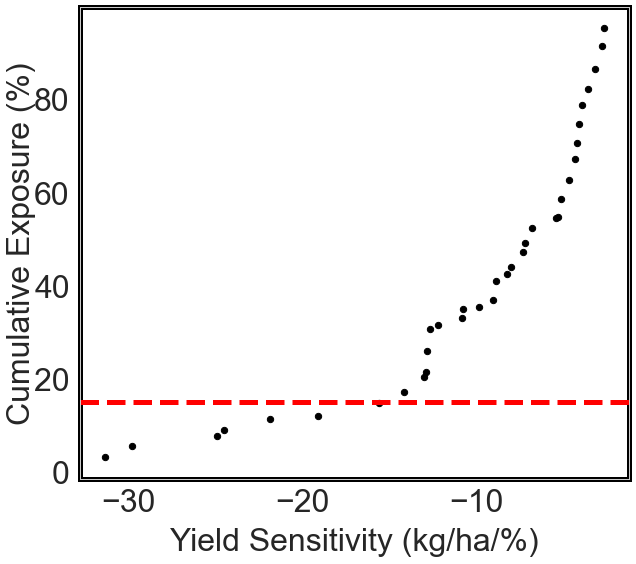

In [137]:
plot_data = ecdf_data.set_index(['rsm_vpd_bin','yield_sensitivity']).sort_index(level=['yield_sensitivity']).cumsum().reset_index()
plot_data

fig, ax = plt.subplots(figsize=(9,8))
fig.subplots_adjust(bottom=-0.5)

ax.scatter(x=np.round(plot_data['yield_sensitivity'],2)[:-1],y=np.round(plot_data['n_b'][:-1],2),c='black',s=40)
ax.set_ylabel('Cumulative Exposure (%)', size=32, labelpad=-2)
ax.set_xlabel('Yield Sensitivity (kg/ha/%)', size=32, labelpad=10)
ax.tick_params(axis='both',which='major',labelsize=32, pad=10)
ax.grid(False)
ax.axhline(y=cut_off, color='red',linestyle='--',linewidth=5)

ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('5')
plt.tight_layout()
plt.savefig('fig/supplementary/'+crop_name+'ecdf.pdf',dpi=200)
plt.savefig('fig/supplementary/'+crop_name+'ecdf.png',dpi=200)

In [57]:
plot_data.to_csv('outputs/'+crop_name+'_exposure_based_ecdf.csv')